In [25]:
%matplotlib inline
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
X = torch.randn(1000, 2)
A = torch.Tensor([[1, 2], [-0.1, 0.5]])
b = torch.Tensor([1, 2])
data = torch.matmul(X, A) + b
print(data)
label = torch.ones(1000, 1)

tensor([[ 0.7632,  2.0286],
        [ 2.5575,  5.7623],
        [ 1.1009,  2.5178],
        ...,
        [-0.2369, -0.1267],
        [ 0.9152,  0.7046],
        [ 1.0761,  2.4066]])


The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


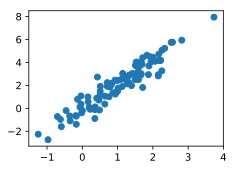

In [27]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy())
print("The covariance matrix is\n%s" % torch.mm(A.t(), A))

In [28]:
batch_size = 8
data_iter = d2l.load_array(data.numpy(), label.numpy(), batch_size)


In [29]:
net_G = nn.Sequential(
            nn.Linear(in_features=2,out_features=2)
)

In [30]:
net_D = nn.Sequential(
            nn.Linear(in_features=2,out_features=5),
            nn.Tanh(),
            nn.Linear(in_features=5,out_features=3),
            nn.Tanh(),
            nn.Linear(in_features=3,out_features=1),
            nn.Sigmoid()
)

In [31]:
# Saved in the d2l package for later use
def update_D(X, Z, net_D, net_G, loss, trainer_D): 
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones(batch_size)
    zeros = torch.zeros(batch_size)
    trainer_D.zero_grad()

    real_Y = net_D(X)
    fake_X = net_G(Z)
    # print(X,fake_X)
    fake_Y = net_D(fake_X.detach())
    
    loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    loss_D.backward()
    trainer_D.step()
    # print(loss_D)
    return float(loss_D.sum())

In [32]:
# Saved in the d2l package for later use
def update_G(Z, net_D, net_G, loss, trainer_G): # saved in d2l
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones(batch_size)
    trainer_G.zero_grad()

    # We could reuse fake_X from update_D to save computation.
    fake_X = net_G(Z)
    # Recomputing fake_Y is needed since net_D is changed.
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones)
    loss_G.backward()
    trainer_G.step()
    return float(loss_G.sum())

In [33]:
def train(net_D, net_G, data_iter, num_epochs, device, lr_D, lr_G, latent_dim, data):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    net_D.apply(init_weights)
    net_D = net_D.to(device)
    net_D.train()

    net_G.apply(init_weights)
    net_G = net_G.to(device)
    net_G.train()

    loss = nn.BCELoss(size_average=False)
    trainer_D = optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['generator', 'discriminator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs+1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples 
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.randn(batch_size, latent_dim)
            # print(Z)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                        update_G(Z, net_D, net_G, loss, trainer_G),
                        batch_size)
        # Visualize generated examples
        Z = torch.randn(100, latent_dim)
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch, (loss_D, loss_G))
        print('loss_D %.3f, loss_G %.3f, %d examples/sec' % (
                loss_D, loss_G, metric[2]/timer.stop()))

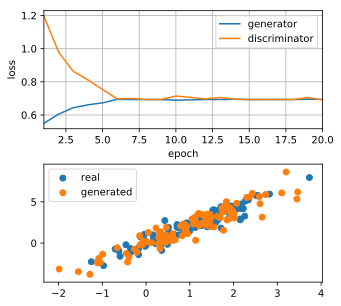

loss_D 0.694, loss_G 0.692, 3019 examples/sec


In [34]:
lr_D, lr_G, latent_dim, num_epochs, device = 0.05, 0.005, 2, 20, d2l.try_gpu()

train(net_D, net_G, data_iter, num_epochs, device, lr_D, lr_G, 
      latent_dim, data[:100].numpy())